In [4]:
#| default_exp gym

In [ ]:
#| export
import jax
import jax.numpy as jnp
from gymnax.environments import environment, spaces
from typing import Tuple, Optional
from functools import partial
from jax.tree_util import tree_map

# Assuming the 'chewc' library files are in the path
from chewc.structs import Population, BreedingState, Trait, GeneticMap, quick_haplo, add_trait
from chewc.pheno import calculate_phenotypes
from chewc.cross import random_mating, cross_pair

class StoaEnv(environment.Environment):
    """
    A Gymnax environment for the ChewC breeding simulation.
    
    The agent's goal is to maximize the genetic gain of the population
    over a fixed number of generations by choosing the selection intensity at each step.
    """

    def __init__(self, n_founders=100, n_pop_size=200, n_chr=5, n_loci=1000, n_qtl_per_chr=50, total_gen=20, max_crossovers=10):
        super().__init__()
        self.n_founders = n_founders
        self.n_pop_size = n_pop_size
        self.total_gen = total_gen
        self.max_crossovers = max_crossovers
        self.n_chr = n_chr
        self.n_loci = n_loci
        self.n_qtl_per_chr = n_qtl_per_chr
        
        key = jax.random.PRNGKey(42)
        pop_key, trait_key = jax.random.split(key)

        # Founder pop is created once and reused for every reset
        self.founder_pop, self.genetic_map = quick_haplo(
            key=pop_key, n_ind=self.n_founders, n_chr=self.n_chr, seg_sites=self.n_loci
        )

        self.trait_architecture = add_trait(
            key=trait_key,
            founder_pop=self.founder_pop,
            n_qtl_per_chr=self.n_qtl_per_chr,
            mean=jnp.array([100.0]),
            var_a=jnp.array([10.0]),
            var_d=jnp.array([0.0]),
            sigma=jnp.array([[1.0]])
        )
        self.heritabilities = jnp.array([0.5])

    @property
    def default_params(self):
        return {}

    def step_env(self, key: jax.Array, state: BreedingState, action: jax.Array, params) -> Tuple[jax.Array, BreedingState, float, bool, dict]:
        key, pheno_key, mating_key, cross_key = jax.random.split(key, 4)
        current_pop = state.population
        
        selection_proportion = (action[0] + 1) / 2 * (0.95 - 0.05) + 0.05
        
        phenotypes, _ = calculate_phenotypes(
            key=pheno_key,
            population=current_pop,
            trait=self.trait_architecture,
            heritability=self.heritabilities
        )
        
        n_current_pop = current_pop.geno.shape[0]
        n_select = (n_current_pop * selection_proportion).astype(jnp.int32)
        n_select = jnp.maximum(2, n_select)
        
        sorted_indices = jnp.argsort(-phenotypes[:, 0].flatten())
        sorted_parent_pool = tree_map(lambda x: x[sorted_indices], current_pop)

        pairings = random_mating(mating_key, n_parents=n_select, n_crosses=self.n_pop_size)
        mother_indices, father_indices = pairings[:, 0], pairings[:, 1]
        
        mothers_geno = sorted_parent_pool.geno[mother_indices]
        fathers_geno = sorted_parent_pool.geno[father_indices]
        mothers_ibd = sorted_parent_pool.ibd[mother_indices]
        fathers_ibd = sorted_parent_pool.ibd[father_indices]
        
        vmapped_cross = jax.vmap(cross_pair, in_axes=(0, 0, 0, 0, 0, None, None))
        offspring_keys = jax.random.split(cross_key, self.n_pop_size)
        offspring_geno, offspring_ibd = vmapped_cross(
            offspring_keys, mothers_geno, fathers_geno, mothers_ibd, fathers_ibd, self.genetic_map, self.max_crossovers
        )
        
        new_generation = state.generation + 1
        new_ids = jnp.arange(self.n_pop_size, dtype=jnp.int32) + state.next_id
        new_meta = jnp.stack([
            new_ids,
            sorted_parent_pool.meta[mother_indices, 0],
            sorted_parent_pool.meta[father_indices, 0],
            jnp.full((self.n_pop_size,), new_generation, dtype=jnp.int32),
        ], axis=-1)
        
        new_population = Population(geno=offspring_geno, ibd=offspring_ibd, meta=new_meta)
        
        next_state = BreedingState(
            population=new_population, key=key, generation=new_generation, next_id=state.next_id + self.n_pop_size
        )
        
        done = next_state.generation >= self.total_gen

        def get_final_reward(final_state: BreedingState):
            reward_key, _ = jax.random.split(final_state.key)
            _, tbvs = calculate_phenotypes(
                reward_key, final_state.population, self.trait_architecture, self.heritabilities
            )
            return jnp.mean(tbvs[:, 0])

        reward = jax.lax.cond(done, get_final_reward, lambda s: 0.0, operand=next_state)
        
        obs = self._get_obs(next_state)
        return obs, next_state, reward, done, {}

    def reset_env(self, key: jax.Array, params) -> Tuple[jax.Array, BreedingState]:
        """
        Resets the environment. Includes a "burn-in" step to ensure the
        initial population size matches the ongoing population size, which is
        required for JAX's conditional logic in auto-resetting environments.
        """
        # Create a new state with the small founder population at generation 0
        burn_in_key, pheno_key, mating_key, cross_key = jax.random.split(key, 4)
        founder_state = BreedingState(
            population=self.founder_pop, key=burn_in_key, generation=0, next_id=self.n_founders
        )
        
        # --- Perform a single burn-in breeding step to reach `n_pop_size` ---
        phenotypes, _ = calculate_phenotypes(
            pheno_key, founder_state.population, self.trait_architecture, self.heritabilities
        )
        
        # Select top 50% of founders by default for the first cross
        n_select = jnp.maximum(2, self.n_founders // 2)
        sorted_indices = jnp.argsort(-phenotypes[:, 0].flatten())
        sorted_founders = tree_map(lambda x: x[sorted_indices], founder_state.population)
        
        pairings = random_mating(mating_key, n_parents=n_select, n_crosses=self.n_pop_size)
        mother_indices, father_indices = pairings[:, 0], pairings[:, 1]
        
        mothers_geno = sorted_founders.geno[mother_indices]
        fathers_geno = sorted_founders.geno[father_indices]
        mothers_ibd = sorted_founders.ibd[mother_indices]
        fathers_ibd = sorted_founders.ibd[father_indices]

        vmapped_cross = jax.vmap(cross_pair, in_axes=(0, 0, 0, 0, 0, None, None))
        offspring_keys = jax.random.split(cross_key, self.n_pop_size)
        offspring_geno, offspring_ibd = vmapped_cross(
            offspring_keys, mothers_geno, fathers_geno, mothers_ibd, fathers_ibd, self.genetic_map, self.max_crossovers
        )
        
        # This is the actual initial state for the agent at generation 1
        initial_gen = 1
        initial_ids = jnp.arange(self.n_pop_size, dtype=jnp.int32) + founder_state.next_id
        initial_meta = jnp.stack([
            initial_ids,
            sorted_founders.meta[mother_indices, 0],
            sorted_founders.meta[father_indices, 0],
            jnp.full((self.n_pop_size,), initial_gen, dtype=jnp.int32),
        ], axis=-1)
        
        initial_pop = Population(geno=offspring_geno, ibd=offspring_ibd, meta=initial_meta)
        
        # The state returned to the agent
        initial_state = BreedingState(
            population=initial_pop, key=key, generation=initial_gen, next_id=founder_state.next_id + self.n_pop_size
        )

        obs = self._get_obs(initial_state)
        return obs, initial_state

    def _get_obs(self, state: BreedingState) -> jax.Array:
        remaining_gen = jnp.maximum(0.0, (self.total_gen - state.generation) / self.total_gen)
        pheno_key, _ = jax.random.split(state.key)
        phenotypes, _ = calculate_phenotypes(
            key=pheno_key, population=state.population, trait=self.trait_architecture, heritability=self.heritabilities
        )
        pheno_trait_1 = phenotypes[:, 0]
        genetic_mean = jnp.mean(pheno_trait_1)
        genetic_var = jnp.var(pheno_trait_1)
        return jnp.array([remaining_gen, genetic_mean, genetic_var])

    def observation_space(self, params):
        low = jnp.array([0.0, -jnp.inf, 0.0], dtype=jnp.float32)
        high = jnp.array([1.0, jnp.inf, jnp.inf], dtype=jnp.float32)
        return spaces.Box(low, high, (3,), dtype=jnp.float32)

    def action_space(self, params):
        return spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=jnp.float32)


AttributeError: partially initialized module 'jax' has no attribute 'version' (most likely due to a circular import)

,action,reward_mean,phenotype_mean,tbv_mean
0,-1.0,25.994630,119.964803,25.994630
1,-0.5,43.662437,137.652362,43.662437


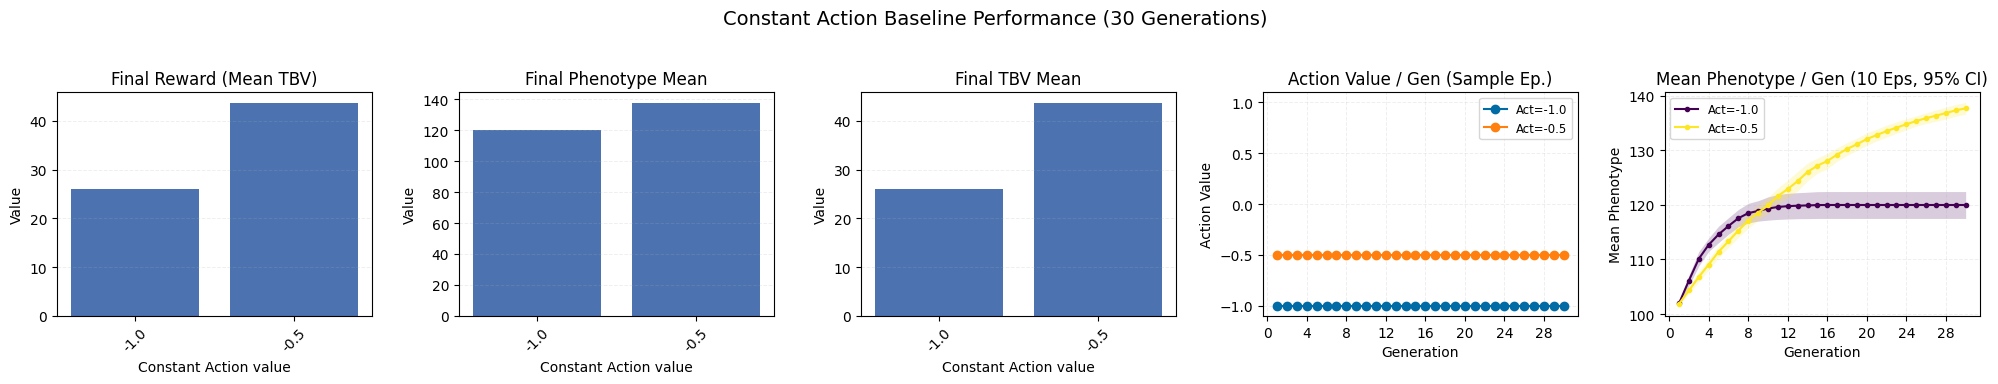

In [6]:
#| export
import jax
import jax.numpy as jnp
from gymnax.environments import environment, spaces
from typing import Tuple, Optional, List, Dict # Added List, Dict
from functools import partial
from jax.tree_util import tree_map

# Assuming the 'chewc' library files are in the path
from chewc.structs import Population, BreedingState, Trait, GeneticMap, quick_haplo, add_trait
from chewc.pheno import calculate_phenotypes
from chewc.cross import random_mating, cross_pair

class StoaEnv(environment.Environment):
    """
    A Gymnax environment for the ChewC breeding simulation.

    The agent's goal is to maximize the genetic gain of the population
    over a fixed number of generations by choosing the selection intensity at each step.
    """

    def __init__(self, n_founders=100, n_pop_size=200, n_chr=5, n_loci=1000, n_qtl_per_chr=50, total_gen=20, max_crossovers=10):
        super().__init__()
        self.n_founders = n_founders
        self.n_pop_size = n_pop_size
        self.total_gen = total_gen
        self.max_crossovers = max_crossovers
        self.n_chr = n_chr
        self.n_loci = n_loci
        self.n_qtl_per_chr = n_qtl_per_chr

        key = jax.random.PRNGKey(42)
        pop_key, trait_key = jax.random.split(key)

        # Founder pop is created once and reused for every reset
        self.founder_pop, self.genetic_map = quick_haplo(
            key=pop_key, n_ind=self.n_founders, n_chr=self.n_chr, seg_sites=self.n_loci
        )

        self.trait_architecture = add_trait(
            key=trait_key,
            founder_pop=self.founder_pop,
            n_qtl_per_chr=self.n_qtl_per_chr,
            mean=jnp.array([100.0]),
            var_a=jnp.array([10.0]),
            var_d=jnp.array([0.0]),
            sigma=jnp.array([[1.0]])
        )
        self.heritabilities = jnp.array([0.5])

    @property
    def default_params(self):
        return {}

    def step_env(self, key: jax.Array, state: BreedingState, action: jax.Array, params) -> Tuple[jax.Array, BreedingState, float, bool, dict]:
        key, pheno_key, mating_key, cross_key = jax.random.split(key, 4)
        current_pop = state.population

        # Map action from [-1, 1] to selection proportion [0.05, 0.95]
        selection_proportion = (action[0] + 1) / 2 * (0.95 - 0.05) + 0.05

        phenotypes, _ = calculate_phenotypes(
            key=pheno_key,
            population=current_pop,
            trait=self.trait_architecture,
            heritability=self.heritabilities
        )

        n_current_pop = current_pop.geno.shape[0]
        n_select = (n_current_pop * selection_proportion).astype(jnp.int32)
        # Ensure at least 2 parents are selected for mating
        n_select = jnp.maximum(2, n_select)

        # Select top individuals based on phenotype
        sorted_indices = jnp.argsort(-phenotypes[:, 0].flatten())
        sorted_parent_pool = tree_map(lambda x: x[sorted_indices], current_pop)

        # Perform random mating among selected parents
        pairings = random_mating(mating_key, n_parents=n_select, n_crosses=self.n_pop_size)
        mother_indices, father_indices = pairings[:, 0], pairings[:, 1]

        mothers_geno = sorted_parent_pool.geno[mother_indices]
        fathers_geno = sorted_parent_pool.geno[father_indices]
        mothers_ibd = sorted_parent_pool.ibd[mother_indices]
        fathers_ibd = sorted_parent_pool.ibd[father_indices]

        # Generate offspring
        vmapped_cross = jax.vmap(cross_pair, in_axes=(0, 0, 0, 0, 0, None, None))
        offspring_keys = jax.random.split(cross_key, self.n_pop_size)
        offspring_geno, offspring_ibd = vmapped_cross(
            offspring_keys, mothers_geno, fathers_geno, mothers_ibd, fathers_ibd, self.genetic_map, self.max_crossovers
        )

        # Update state for the next generation
        new_generation = state.generation + 1
        new_ids = jnp.arange(self.n_pop_size, dtype=jnp.int32) + state.next_id
        new_meta = jnp.stack([
            new_ids,
            sorted_parent_pool.meta[mother_indices, 0], # Mother ID
            sorted_parent_pool.meta[father_indices, 0], # Father ID
            jnp.full((self.n_pop_size,), new_generation, dtype=jnp.int32), # Generation number
        ], axis=-1)

        new_population = Population(geno=offspring_geno, ibd=offspring_ibd, meta=new_meta)

        next_state = BreedingState(
            population=new_population, key=key, generation=new_generation, next_id=state.next_id + self.n_pop_size
        )

        # Check if the episode is done
        done = next_state.generation >= self.total_gen

        # Calculate reward only at the end of the episode (mean TBV of the final population)
        def get_final_reward(final_state: BreedingState):
            reward_key, _ = jax.random.split(final_state.key)
            _, tbvs = calculate_phenotypes(
                reward_key, final_state.population, self.trait_architecture, self.heritabilities
            )
            return jnp.mean(tbvs[:, 0])

        # If done, compute final reward, otherwise reward is 0 for intermediate steps
        reward = jax.lax.cond(done, get_final_reward, lambda s: 0.0, operand=next_state)

        obs = self._get_obs(next_state)
        # Include current phenotype mean and std in info for logging
        info = {} # Can add pheno mean/std here if needed outside the evaluation script

        return obs, next_state, reward, done, info

    def reset_env(self, key: jax.Array, params) -> Tuple[jax.Array, BreedingState]:
        """
        Resets the environment. Includes a "burn-in" step to ensure the
        initial population size matches the ongoing population size, which is
        required for JAX's conditional logic in auto-resetting environments.
        """
        # Create a new state with the small founder population at generation 0
        burn_in_key, pheno_key, mating_key, cross_key = jax.random.split(key, 4)
        founder_state = BreedingState(
            population=self.founder_pop, key=burn_in_key, generation=0, next_id=self.n_founders
        )

        # --- Perform a single burn-in breeding step to reach `n_pop_size` ---
        phenotypes, _ = calculate_phenotypes(
            pheno_key, founder_state.population, self.trait_architecture, self.heritabilities
        )

        # Select top 50% of founders by default for the first cross
        n_select = jnp.maximum(2, self.n_founders // 2)
        sorted_indices = jnp.argsort(-phenotypes[:, 0].flatten())
        sorted_founders = tree_map(lambda x: x[sorted_indices], founder_state.population)

        pairings = random_mating(mating_key, n_parents=n_select, n_crosses=self.n_pop_size)
        mother_indices, father_indices = pairings[:, 0], pairings[:, 1]

        mothers_geno = sorted_founders.geno[mother_indices]
        fathers_geno = sorted_founders.geno[father_indices]
        mothers_ibd = sorted_founders.ibd[mother_indices]
        fathers_ibd = sorted_founders.ibd[father_indices]

        vmapped_cross = jax.vmap(cross_pair, in_axes=(0, 0, 0, 0, 0, None, None))
        offspring_keys = jax.random.split(cross_key, self.n_pop_size)
        offspring_geno, offspring_ibd = vmapped_cross(
            offspring_keys, mothers_geno, fathers_geno, mothers_ibd, fathers_ibd, self.genetic_map, self.max_crossovers
        )

        # This is the actual initial state for the agent at generation 1
        initial_gen = 1
        initial_ids = jnp.arange(self.n_pop_size, dtype=jnp.int32) + founder_state.next_id
        initial_meta = jnp.stack([
            initial_ids,
            sorted_founders.meta[mother_indices, 0], # Mother ID
            sorted_founders.meta[father_indices, 0], # Father ID
            jnp.full((self.n_pop_size,), initial_gen, dtype=jnp.int32), # Generation number
        ], axis=-1)

        initial_pop = Population(geno=offspring_geno, ibd=offspring_ibd, meta=initial_meta)

        # The state returned to the agent
        initial_state = BreedingState(
            population=initial_pop, key=key, generation=initial_gen, next_id=founder_state.next_id + self.n_pop_size
        )

        obs = self._get_obs(initial_state)
        return obs, initial_state

    def _get_obs(self, state: BreedingState) -> jax.Array:
        # Observation includes: remaining generations ratio, mean phenotype, variance of phenotype
        remaining_gen = jnp.maximum(0.0, (self.total_gen - state.generation) / self.total_gen)
        pheno_key, state_key = jax.random.split(state.key) # Split key for pheno calc
        phenotypes, _ = calculate_phenotypes(
            key=pheno_key, population=state.population, trait=self.trait_architecture, heritability=self.heritabilities
        )
        pheno_trait_1 = phenotypes[:, 0]
        genetic_mean = jnp.mean(pheno_trait_1)
        genetic_var = jnp.var(pheno_trait_1)
        # Update state key if observation calculation consumes randomness
        # state = state.replace(key=state_key) # Not needed here as pheno calc key is separate
        return jnp.array([remaining_gen, genetic_mean, genetic_var])

    def observation_space(self, params):
        # Defines the bounds of the observation space
        low = jnp.array([0.0, -jnp.inf, 0.0], dtype=jnp.float32)
        high = jnp.array([1.0, jnp.inf, jnp.inf], dtype=jnp.float32)
        return spaces.Box(low, high, (3,), dtype=jnp.float32)

    def action_space(self, params):
        # Defines the bounds of the action space (single continuous value between -1 and 1)
        return spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=jnp.float32)

# ==============================================================================
# Evaluation Script
# ==============================================================================

import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import scipy.stats # For confidence interval calculation

# Assuming StoaEnv is defined above or imported
# from chewc.gym import StoaEnv
from chewc.pheno import calculate_phenotypes

plt.style.use('tableau-colorblind10')

def run_constant_action_episode(env: StoaEnv, action_value: float, rng_key: jax.Array) -> Tuple[float, float, float, List[int], List[float], List[float], List[float]]:
    """Runs a single episode with a constant action and returns metrics and history."""
    params = env.default_params
    reset_key, rng_key = jax.random.split(rng_key)
    obs, state = env.reset_env(reset_key, params)

    action = jnp.array([action_value], dtype=jnp.float32)
    final_reward = 0.0
    generations_history = []
    actions_history = []
    pheno_means_history = []
    pheno_stds_history = []

    while True:
        # --- Store state *before* taking the step ---
        generations_history.append(int(state.generation))
        actions_history.append(float(action_value))

        # Calculate and store phenotype stats for the current generation's population
        pheno_key, rng_key = jax.random.split(rng_key) # Get a key for phenotype calculation
        phenotypes_current, _ = calculate_phenotypes(
            pheno_key, state.population, env.trait_architecture, env.heritabilities
        )
        pheno_means_history.append(float(jnp.mean(phenotypes_current[:, 0])))
        pheno_stds_history.append(float(jnp.std(phenotypes_current[:, 0])))
        # --- End store state ---

        step_key, rng_key = jax.random.split(rng_key) # Get key for step
        obs, state, reward, done, _ = env.step_env(step_key, state, action, params)
        final_reward = float(reward) # Will be non-zero only on the last step
        if bool(done):
            # Also record stats for the final state after the last step
            generations_history.append(int(state.generation))
            actions_history.append(float(action_value)) # Action that led to this state
            pheno_key, _ = jax.random.split(rng_key) # Use remaining key
            phenotypes_final, tbv_final = calculate_phenotypes(
                pheno_key, state.population, env.trait_architecture, env.heritabilities
            )
            pheno_means_history.append(float(jnp.mean(phenotypes_final[:, 0])))
            pheno_stds_history.append(float(jnp.std(phenotypes_final[:, 0])))
            break # Exit loop

    # Final population metrics (already calculated for the last history entry)
    final_pheno_mean = pheno_means_history[-1]
    final_tbv_mean = float(jnp.mean(tbv_final[:, 0])) # TBV is calculated only once at the end

    return final_reward, final_pheno_mean, final_tbv_mean, generations_history, actions_history, pheno_means_history, pheno_stds_history


def evaluate_constant_actions(
    env: StoaEnv,
    action_values,
    num_episodes: int = 32,
    seed: int = 0,
    confidence_level: float = 0.95, # For confidence interval
) -> pd.DataFrame:
    """Evaluates constant actions over multiple episodes."""
    rng = jax.random.PRNGKey(seed)
    records = []

    for action in action_values:
        # Store metrics across episodes
        rewards = []
        final_phenotype_means = []
        final_tbv_means = []

        # Store time series data across episodes
        episode_pheno_means_timeseries = []
        episode_generations = None # Get from first episode

        for i in range(num_episodes):
            rng, episode_key = jax.random.split(rng)
            (
                reward,
                final_pheno_mean,
                final_tbv_mean,
                gen_hist,
                act_hist,
                pheno_means_hist,
                pheno_stds_hist, # pheno_stds currently not used for CI of mean
            ) = run_constant_action_episode(env, action, episode_key)

            rewards.append(reward)
            final_phenotype_means.append(final_pheno_mean)
            final_tbv_means.append(final_tbv_mean)
            episode_pheno_means_timeseries.append(pheno_means_hist)

            if i == 0: # Only store history from the first run for generations and actions
                episode_generations = gen_hist
                first_episode_actions = act_hist


        # --- Aggregate Time Series Data ---
        # Stack the phenotype means history from all episodes
        pheno_means_array = np.array(episode_pheno_means_timeseries) # Shape: (num_episodes, num_generations+1)

        # Calculate mean and SEM across episodes for each generation
        avg_pheno_means_over_time = np.mean(pheno_means_array, axis=0)
        std_pheno_means_over_time = np.std(pheno_means_array, axis=0, ddof=1) if num_episodes > 1 else np.zeros_like(avg_pheno_means_over_time)
        sem_pheno_means_over_time = std_pheno_means_over_time / np.sqrt(num_episodes) if num_episodes > 1 else np.zeros_like(avg_pheno_means_over_time)

        # Calculate confidence interval bounds
        alpha = 1.0 - confidence_level
        z_score = scipy.stats.norm.ppf(1.0 - alpha / 2.0) # Z-score for CI
        ci_lower = avg_pheno_means_over_time - z_score * sem_pheno_means_over_time
        ci_upper = avg_pheno_means_over_time + z_score * sem_pheno_means_over_time
        # --- End Aggregation ---

        records.append(
            {
                'action': float(action),
                # Final value stats
                'reward_mean': float(np.mean(rewards)),
                'reward_std': float(np.std(rewards, ddof=1)) if num_episodes > 1 else 0.0,
                'phenotype_mean': float(np.mean(final_phenotype_means)),
                'phenotype_std': float(np.std(final_phenotype_means, ddof=1)) if num_episodes > 1 else 0.0,
                'tbv_mean': float(np.mean(final_tbv_means)),
                'tbv_std': float(np.std(final_tbv_means, ddof=1)) if num_episodes > 1 else 0.0,
                # History from first episode
                'generations_history': episode_generations,
                'actions_history': first_episode_actions,
                # Aggregated time series
                'avg_pheno_means_over_time': avg_pheno_means_over_time.tolist(),
                'pheno_ci_lower_over_time': ci_lower.tolist(),
                'pheno_ci_upper_over_time': ci_upper.tolist(),
            }
        )

    return pd.DataFrame.from_records(records)

# --- Simulation & Plotting ---
N_GEN = 30 # Increase generations slightly for better viz
N_EPISODES = 10 # Reduce episodes for quicker testing, increase for smoother CI

gym = StoaEnv(total_gen=N_GEN, n_pop_size=50)

baseline_actions = [-1.0, -0.5] # Evaluate more actions
baseline_df = evaluate_constant_actions(gym, baseline_actions, num_episodes=N_EPISODES, seed=0)
display(baseline_df[['action', 'reward_mean', 'phenotype_mean', 'tbv_mean']]) # Display main results

# Create 5 subplots (3 bar, 1 action hist, 1 pheno hist)
fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharex=False) # Increased figure size

metrics = [
    ('reward_mean', 'Final Reward (Mean TBV)'),
    ('phenotype_mean', 'Final Phenotype Mean'),
    ('tbv_mean', 'Final TBV Mean'),
]

# Plot Bar Charts for final metrics
for i, (column, title) in enumerate(metrics):
    ax = axes[i]
    ax.bar(baseline_df['action'].astype(str), baseline_df[column], color='#4c72b0') # Use action as string for category
    ax.set_title(title)
    ax.set_xlabel('Constant Action value')
    ax.set_ylabel('Value')
    ax.grid(axis='y', alpha=0.2, linestyle='--', linewidth=0.7)
    ax.tick_params(axis='x', rotation=45) # Rotate labels if needed

# Plot Action History (Sample Episode)
ax_act_hist = axes[3]
for index, row in baseline_df.iterrows():
    # Ensure generation history matches action history length (might differ by 1 due to final state)
    gen_hist_plot = row['generations_history'][:len(row['actions_history'])]
    ax_act_hist.plot(
        gen_hist_plot,
        row['actions_history'],
        marker='o', # Add markers to see individual steps
        linestyle='-',
        label=f"Act={row['action']:.1f}"
    )

ax_act_hist.set_title('Action Value / Gen (Sample Ep.)')
ax_act_hist.set_xlabel('Generation')
ax_act_hist.set_ylabel('Action Value')
ax_act_hist.set_ylim(-1.1, 1.1) # Set Y-axis limits based on action space
ax_act_hist.legend(fontsize='small')
ax_act_hist.grid(axis='both', alpha=0.2, linestyle='--', linewidth=0.7)
ax_act_hist.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Plot Phenotype Mean History with Confidence Interval (NEW PLOT)
ax_pheno_hist = axes[4]
colors = plt.cm.viridis(np.linspace(0, 1, len(baseline_df))) # Get distinct colors

for i, (index, row) in enumerate(baseline_df.iterrows()):
    generations = row['generations_history']
    avg_means = row['avg_pheno_means_over_time']
    ci_lower = row['pheno_ci_lower_over_time']
    ci_upper = row['pheno_ci_upper_over_time']

    ax_pheno_hist.plot(
        generations,
        avg_means,
        marker='.',
        linestyle='-',
        color=colors[i],
        label=f"Act={row['action']:.1f}"
    )
    ax_pheno_hist.fill_between(
        generations,
        ci_lower,
        ci_upper,
        color=colors[i],
        alpha=0.2,
        linewidth=0 # No border for fill
    )

ax_pheno_hist.set_title(f'Mean Phenotype / Gen ({N_EPISODES} Eps, 95% CI)')
ax_pheno_hist.set_xlabel('Generation')
ax_pheno_hist.set_ylabel('Mean Phenotype')
ax_pheno_hist.legend(fontsize='small')
ax_pheno_hist.grid(axis='both', alpha=0.2, linestyle='--', linewidth=0.7)
ax_pheno_hist.xaxis.set_major_locator(plt.MaxNLocator(integer=True))


fig.suptitle(f'Constant Action Baseline Performance ({N_GEN} Generations)', fontsize=14)
fig.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()